In [1]:
# builtin deps
import typing as t
from pathlib import Path
from collections import defaultdict

# third parties deps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint

## Load data from clean_datasets dir

In [2]:
CLEAN_DATASETS_DIR = Path("./clean_datasets")

In [3]:
hourly_dfs = defaultdict(lambda : pd.DataFrame())

for path in CLEAN_DATASETS_DIR.iterdir():
    file_name_wo_ext = path.name.split('.')[0]
    hourly_dfs[file_name_wo_ext] = pd.read_csv(path, index_col=0)
    # convert index to timestamp for further implementation
    hourly_dfs[file_name_wo_ext].index = pd.to_datetime(hourly_dfs[file_name_wo_ext].index)

# add total_people in dataframe
hourly_dfs['people']['total_people'] = \
    hourly_dfs['people']['zone1']\
    + hourly_dfs['people']['zone2']\
    + hourly_dfs['people']['zone3']\
    + hourly_dfs['people']['zone4']

## Check number of entry for hourly data

In [5]:
for name in hourly_dfs:
    print(f"{name}\n", "number of entries:", len(hourly_dfs[name]), end="\n\n")

meter1_phase1
 number of entries: 610

people
 number of entries: 152

weather
 number of entries: 986

meter2_phase1
 number of entries: 610



## Check completeness of the time series data

In [8]:
def check_completeness(dfs):
    
    for name in dfs:
        
        # calculate number of hours in the time series interval
        time_delta = dfs[name].index[-1] - dfs[name].index[0]
        expected_hours = time_delta.days*24 + time_delta.seconds//3600 + 1
        
        print(name, f"--> completness {len(dfs[name])/expected_hours*100:.0f}%")
        print(f"expected num hours: {expected_hours:,d} number of entries: {len(dfs[name]):,d}", end="\n\n")

In [9]:
check_completeness(hourly_dfs)

meter1_phase1 --> completness 99%
expected num hours: 618 number of entries: 610

people --> completness 16%
expected num hours: 935 number of entries: 152

weather --> completness 100%
expected num hours: 986 number of entries: 986

meter2_phase1 --> completness 99%
expected num hours: 618 number of entries: 610



*The completeness of the people dataset is too low*

## Combine meter1 and meter 2 data with inner join

In [10]:
hourly_dfs['total_meter'] = hourly_dfs['meter2_phase1']\
    .join(hourly_dfs['meter1_phase1'], lsuffix='_meter2', rsuffix='_meter1', how='inner')

In [11]:
# calculate total power of this hotel
hourly_dfs['total_meter']['total_power'] = \
    hourly_dfs['total_meter']['power_meter1'] \
    + hourly_dfs['total_meter']['power_meter2']

## Combine total_meter and weather data using inner join

In [12]:
hourly_dfs['meters_weather'] = hourly_dfs['total_meter'].join(hourly_dfs['weather'], how='inner')

## Combine total_meter and people data using inner join

In [13]:
hourly_dfs['meters_people'] = hourly_dfs['total_meter'].join(hourly_dfs['people'], how='inner')

## Combine total_meter, weather, people data using inner join

In [14]:
hourly_dfs['mwp'] = hourly_dfs['meters_weather'].join(hourly_dfs['people'], how='inner')

## Partition aggregated dataset 
To train ml on such inconsecutive time series will lower the performance.  
Thus, I will partitioned into several bucket, each bucket containg consecutive time series.

In [15]:
def partition_dfs(df: pd.DataFrame, 
                  threshold: int) -> t.Tuple[t.Dict[int, pd.DataFrame], t.List[int], int]:
    """Partition consecutive dataset given some threshold"""
    # output bucket
    dfs = defaultdict(lambda: pd.DataFrame())
    # list of integer, which tell us the diff hours of each bucket
    diff_hs = []
    section = 0
    i = 0

    for ind in range(1, len(df)):
        diff = df.iloc[ind:ind+1].index[0] - df.iloc[ind-1:ind].index[0]
        diff_h = diff.days*24 + diff.seconds//3600

        if diff_h > threshold :
            dfs[section] = df.iloc[i:ind].copy()
            diff_hs.append(diff_h)

            # inc i and section
            i = ind
            section += 1

        # append the last bucket into the result
        if ind == len(df) - 1:
            dfs[section] = df.iloc[i:ind].copy()
            
    return dfs, diff_hs, np.argmax([*map(lambda key: len(dfs[key]), dfs)])

In [16]:
mwp_part_dfs, diff_hs, argmax = partition_dfs(hourly_dfs['mwp'], 3)

In [17]:
print("length of each bucket: ", *map(lambda key: len(mwp_part_dfs[key]), mwp_part_dfs))
print("diff hour of each buket: ", *diff_hs)

length of each bucket:  3 2 18 2 27 11 2 67
diff hour of each buket:  9 16 9 5 4 77 82


In [18]:
mwp_part_df = mwp_part_dfs[argmax]

# 1 hour ahead forecasting ML model

## Extract the data from database and append postional encoder (hour of the day)

In [20]:
df = mwp_part_df.copy()
df['hour'] = mwp_part_df.index.hour

## extract data from mwp_df to be trained in the model

In [21]:
def split_train_test(df, target_df, num_split):
    X_train, y_train = df[:num_split], target_df[:num_split]
    X_test, y_test = df[num_split:], target_df[num_split:]
    return X_train, y_train, X_test, y_test

In [22]:
num_split = int(len(df)*0.8)

X_train, y_train, X_test, y_test = split_train_test(
    df[['total_people', 'temp_c', 'total_power', 'hour']], 
    df['total_people'], 
    num_split)

## Create window function to prepare train and test set

In [23]:
def window(train, target, window_size):
    train_w = np.array([])
    target_w = np.array([])
    
    for i in range(window_size, len(train)):
        if len(train_w) == 0:
            train_w = train[i-window_size:i].to_numpy().flatten().reshape([1, -1])
            target_w = np.array([target[i]])
            
        train_w = np.append(train_w, train[i-window_size:i].to_numpy().flatten().reshape([1, -1]), axis=0)
        target_w = np.append(target_w, target[i])
        
    return train_w, target_w

In [24]:
# test window function
train_w, target_w = window(X_test, y_test, 3)

print('train shape: ', train_w.shape)
print('target shape: ', target_w.shape)

train shape:  (12, 12)
target shape:  (12,)


## Customized search function to tune Hyperparameter  
*window size is another hyperparam which cannot be tune inside the cvsearch*  
So, I have to literally loop outside the randomized search cv and find the best windowsize

In [25]:
def window_width_search(pipe, param_grids, tscv, train, target, n_iter=10):
    records = {}
    best_score_ = -1 << 31
    best_estimator_ = None
    best_window_size = 0

    for i in range(1, 20):
        train_w, target_w = window(train, target, i)
        np.random.seed(42)
        clf = RandomizedSearchCV(pipe, param_grids, cv=tscv, n_iter=n_iter)
        clf.fit(train_w, target_w)

        if clf.best_score_ > best_score_:
            best_score_ = clf.best_score_
            best_estimator = clf
            best_window_size = i

        records[i] = {'best_params': clf.best_params_, "best scores: ": clf.best_score_}
        
    return best_estimator, best_window_size, best_score_, records

In [26]:
# time series splitter
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
def plot_results(estimator, x, y, window_width):
    train_w, target_w = window(x, y, window_width)
    plt.figure(figsize=(10, 6))
    plt.plot(x.index[window_width-1:], estimator.predict(train_w))
    plt.plot(x.index[window_width-1:], target_w)
    plt.grid(True)
    plt.legend(['predicted', 'actual'])

## Lasso pipeline

In [60]:
ridge = Ridge()
scaler = StandardScaler()

pipe = Pipeline([
    ('scaler', scaler), 
    ('estimator', ridge)
])

param_grids = {'estimator__alpha': uniform(loc=0, scale=10)}

In [61]:
best_ridge, best_window_width, best_score, records = window_width_search(pipe, 
                                                                            param_grids, 
                                                                            tscv,
                                                                            X_train,
                                                                            y_train
                                                                           )

In [62]:
print("=== Rdige model report ===")
print("best cv score: {:.2f}".format(best_score))
print("best cv window size: {:d}".format(best_window_width))

X_test_w, y_test_w = window(X_test, y_test, best_window_width)
print("test r^2: {:.2f}".format(best_ridge.score(X_test_w, y_test_w)))

=== Rdige model report ===
best cv score: -0.29
best cv window size: 9
test r^2: -0.33


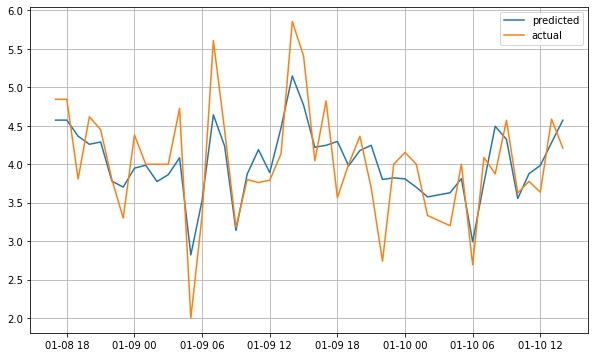

In [63]:
plot_results(best_ridge, X_train, y_train, best_window_width)

## Random forest pipeline

In [39]:
rdf = RandomForestRegressor()
scaler = StandardScaler()

rdf_pipe = Pipeline([
    ('scaler', scaler), 
    ('estimator', rdf)
])

param_grids = {
    'estimator__n_estimators': randint(5, 30), 
    'estimator__min_samples_split': randint(2, 10),
    'estimator__min_samples_leaf': randint(2, 10)
}

In [40]:
best_rdf, best_window_width, best_score, records = window_width_search(rdf_pipe,  
                                                                            param_grids, 
                                                                            tscv,
                                                                            X_train,
                                                                            y_train
                                                                           )

In [41]:
print("=== Randomforest model report ===")
print("best cv score: {:.2f}".format(best_score))
print("best cv window size: {:d}".format(best_window_width))

X_test_w, y_test_w = window(X_test, y_test, best_window_width)
print("test r^2: {:.2f}".format(best_rdf.score(X_test_w, y_test_w)))

=== Randomforest model report ===
best cv score: -0.04
best cv window size: 8
test r^2: -0.50


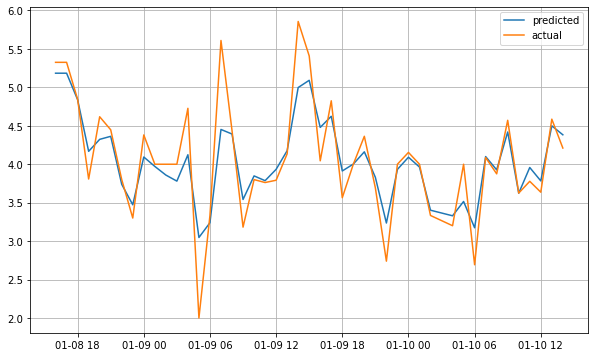

In [42]:
plot_results(best_rdf, X_train, y_train, best_window_width)

## Voting regressor pipeline

In [43]:
scaler = StandardScaler()

rf = RandomForestRegressor()
la = Lasso()
vreg = VotingRegressor([('la', la), ('rf', rf)])

vreg_pipe = Pipeline([
    ('scaler', scaler), 
    ('estimator', vreg)
])

param_grids = {
    'estimator__la__alpha': uniform(loc=0, scale=10),
    'estimator__rf__n_estimators': randint(5, 30), 
    'estimator__rf__min_samples_split': randint(2, 10),
    'estimator__rf__min_samples_leaf': randint(2, 10)
}

In [44]:
best_vreg, best_window_width, best_score, records = window_width_search(vreg_pipe,
                                                                       param_grids,
                                                                       tscv,
                                                                       X_train,
                                                                       y_train)

/Users/boonchuay/Documents 2/hotel-project/env-hotel/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008515765190600377, tolerance: 0.0011428276327248334
  positive)
/Users/boonchuay/Documents 2/hotel-project/env-hotel/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006053942934309942, tolerance: 0.0011314489535841445
  positive)
/Users/boonchuay/Documents 2/hotel-project/env-hotel/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018997261379716246, tolerance: 0.0018131951728087722
  positive)
/Users/boonchuay/Documents 2/hotel-project/env-hotel/lib/python3.7

In [45]:
print("=== Voting regressor model report ===")
print("best cv score: {:.2f}".format(best_score))
print("best cv window size: {:d}".format(best_window_width))

X_test_w, y_test_w = window(X_test, y_test, best_window_width)
print("test r^2: {:.2f}".format(best_vreg.score(X_test_w, y_test_w)))

=== Voting regressor model report ===
best cv score: -0.08
best cv window size: 7
test r^2: -0.48


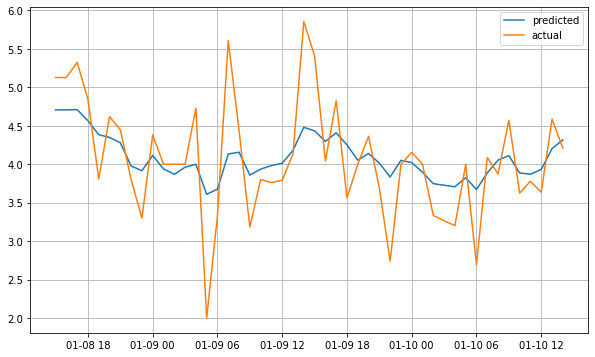

In [46]:
plot_results(best_vreg, X_train, y_train, best_window_width)

## ML model summary  
From the above three model which is. 
1. Lasso regression --> Best window size 9  
2. Random forest classifier --> Best window size 8  
3. Soft voting classifier --> Best window size 7  

We can see that the best performance model is random forest classifier with the cv score (r^2) of -0.05 and test score of -0.53.  
The best window size 8 means that the past 8 hours of historical data should be used to predict the next hour value.  